# CNN and QCNN tests on MNIST handwritten digits dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime

from tensorflow.keras.datasets import mnist

## Quick data exploration

In [2]:
# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()

In [3]:
print(f"Training set shape:\t{trainX.shape}")
print(f"Training labels shape:\t{trainY.shape}")
print(f"Test set shape:\t\t{testX.shape}")
print(f"Test labels shape:\t{testY.shape}")

Training set shape:	(60000, 28, 28)
Training labels shape:	(60000,)
Test set shape:		(10000, 28, 28)
Test labels shape:	(10000,)


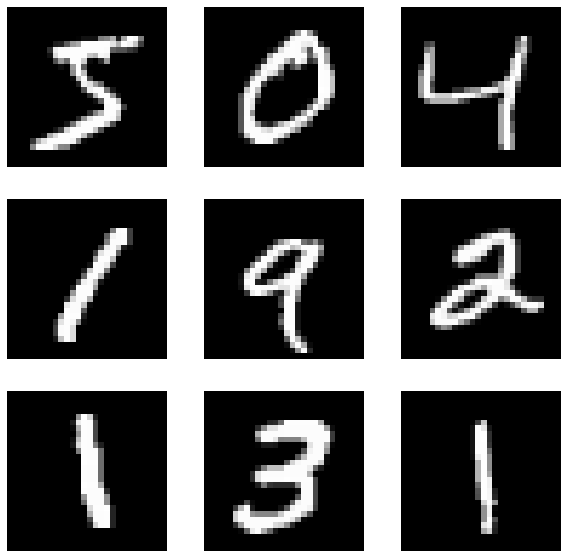

In [4]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    ax = fig.add_subplot(330 + 1 + i)
    ax.axis("off")
    ax.imshow(trainX[i], cmap="gray")
    
plt.show()

## Data preprocessing for CNN

1. we need to change the shape of data to fit the CNN requirements, i.e. we need to add the number of channels as last dimension
2. we need to hot-encode the label set

In [5]:
# grey-scale ==> 1 channel
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
testX  = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)

trainX = trainX.astype("float32")
testX  = testX.astype("float32")
trainX = trainX / 255
testX  = testX / 255

# label one-hot encoding
trainY = tf.keras.utils.to_categorical(trainY)
testY  = tf.keras.utils.to_categorical(testY)

## CNN model

In [6]:
class CNN(tf.keras.Model):
    def __init__(
        self,
        input_dim, # n_samples, image size and channels
        n_classes, # dimension of one-hot encoded labels
        conv_activation    = "relu",
        hidden_activation  = "relu",
        cnn_name           = "my convo neural network",
        **kwargs
    ):
        
        # initialize parent class
        super().__init__(**kwargs)

        # store the model name
        self.cnn_name = cnn_name

        self.input_layer = tf.keras.layers.Input(shape=input_dim[1:], name="input")
        
        self.conv_1  = tf.keras.layers.Conv2D(32, (3, 3), activation=conv_activation, input_shape=input_dim[1:], name="conv_1")
        self.pool_1  = tf.keras.layers.MaxPooling2D((2, 2), name="pool_1")
        self.conv_2  = tf.keras.layers.Conv2D(64, (3, 3), activation=conv_activation, name="conv_2")
        self.conv_3  = tf.keras.layers.Conv2D(64, (3, 3), activation=conv_activation, name="conv_3")
        self.pool_2  = tf.keras.layers.MaxPooling2D((2, 2), name="pool_2")
        self.flatten = tf.keras.layers.Flatten(name="flatten")
        self.dense_1 = tf.keras.layers.Dense(100, activation=hidden_activation, name="dense_1")
        self.out     = tf.keras.layers.Dense(n_classes, activation="softmax", name="output")
        
        self.build(input_shape=input_dim)

        

    def call(self, inputs):
        """the call method deals with model creation"""

        x = self.conv_1(inputs)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        
        return self.out(x)
    
    def summary(self):
        """re-define summary method to fix the output_shape : multiple issue"""

        # create a temporary model with all the computed shapes (thanks to self.call method)
        model = tf.keras.Model(
            inputs  = [self.input_layer], 
            outputs = self.call(self.input_layer),
            name    = self.cnn_name
        )

        # return the model summary with computed shapes
        return model.summary(line_length=100)

In [7]:
input_dim = trainX.shape
n_classes = trainY.shape[-1]

model = CNN(
    input_dim=input_dim,
    n_classes=n_classes,
)

optimizer     = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
loss_function = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "my convo neural network"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, 28, 28, 1)]                     0              
                                                                                                    
 conv_1 (Conv2D)                             (None, 26, 26, 32)                      320            
                                                                                                    
 pool_1 (MaxPooling2D)                       (None, 13, 13, 32)                      0              
                                                                                                    
 conv_2 (Conv2D)                             (None, 11, 11, 64)               

2022-05-03 17:30:33.486515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 17:30:33.486613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Training the model and evaluating its performance

In [8]:
BATCH_SIZE = 32
EPOCHS     = 20

history = model.fit(
    trainX, 
    trainY, 
    batch_size      = BATCH_SIZE,
    epochs          = EPOCHS, 
    validation_data = (testX, testY),
    verbose         = 0,
    callbacks       = [tensorboard_callback]
)

loss, acc = model.evaluate(testX, testY, verbose=0)

2022-05-03 17:30:33.720875: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 17:30:33.885929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-03 17:30:46.129832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [12]:
acc

0.9926000237464905

In [13]:
model.save("models/lai_model_1/", save_format="tf")
#m = tf.keras.models.load_model("models/lai_model_1/")


INFO:tensorflow:Assets written to: models/lai_model_1/assets


2022-05-03 17:37:42.745648: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
# plots

## Make predictions on data